# IS-4100 Lab Assignment: Exploring Poisson Regression with NFL Data

**Objective**

Use NFL play-by-play data to explore and apply Poisson regression for modeling count data. A great use case could be the number of touchdowns scored by teams during games.

**Assignment Overview**

You will work through the following key steps:

**Setup and Data Acquisition**
- Install necessary packages (e.g., `nfl_data_py` or `nflfastR`).
- Import essential libraries for data manipulation and visualization.
- Load NFL play-by-play data.


**Data Preparation and Feature Engineering**
- Compute predictor variables that may influence dependent variable.
- Create a final dataset for modeling, ensuring proper handling of missing values.

**Exploratory Data Analysis (EDA)**
- Visualize the distribution of your response variable.
- Analyze the distribution to assess suitability for Poisson regression.
- Explore relationships between predictors and the target variable.


**Modeling**
- Fit a Poisson Regression Model
- Interpret the Model
- Analyze model coefficients and their statistical significance.
- Explain the effect of each predictor on the expected number of touchdowns.

**Assess Model Fit**
- Evaluate the goodness-of-fit using appropriate metrics.
- Check for overdispersion (variance greater than the mean).


**Model Diagnostics and Refinement**
- If overdispersion is detected:
  - Fit a Negative Binomial regression model as an alternative.
  - Compare the Poisson and Negative Binomial models.
  - Determine which model better fits the data and justify your choice.

**Reporting and Conclusions**
- Summarize your findings in a clear and concise manner.
- Discuss any insights gained from the analysis.
- Reflect on the modeling process, including any challenges or limitations.
- Document your work thoroughly within the notebook, using markdown cells to explain each step.

## Setup and Data Retrieval

In [ ]:
install.packages('nflfastR')
install.packages('tidyverse')
install.packages('broom')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(nflfastR)
library(tidyverse)
library(broom)

In [ ]:
# Load in pbp data
seasons <- c(2016:2023)
pbp <- load_pbp(seasons)

# Filter dataset to only include pass plays
pbp_pass <- pbp |>
  filter(play_type == 'pass') |>  # Changed 'Pass' to 'pass'
  mutate(interception = ifelse(is.na(interception), 0, interception)) |>
  mutate(complete_pass = ifelse(is.na(complete_pass), 0, complete_pass))

## Data Preperation

In [ ]:
pbp_pass_interception <- pbp_pass |>
    group_by(season, week, defteam) |>
    summarize(
        # get num passes col, sum up interceptions
        n_passes = n(),
        passing_yards_allowed = sum(yards_gained),
        interceptions = sum(interception),
        yards_per_pass = mean(yards_gained),
        completion_rate = sum(complete_pass == 1, na.rm = TRUE)/ n_passes,
        .groups = 'keep'
    )

  head(pbp_pass_interception)

season,week,defteam,n_passes,passing_yards_allowed,interceptions,yards_per_pass,completion_rate
<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2016,1,ARI,35,257,0,7.342857,0.6857143
2016,1,ATL,32,281,1,8.781250,0.7187500
2016,1,BAL,24,95,0,3.958333,0.6250000
2016,1,BUF,37,225,0,6.081081,0.5945946
2016,1,CAR,28,159,2,5.678571,0.6428571
2016,1,CHI,37,215,1,5.810811,0.5945946


In [ ]:
# Take the average interceptions for each team for the previous season up to current game

# create empty tibble
int_rate <- tibble()

# nested for loop
for (season_idx in seq(2017, 2023)) {
  for (week_idx in seq(1,22)) {
    # weekly calc
    week_calc_r <-
      pbp_pass_interception |>
        # filter season
        filter((season == (season_idx - 1)) |
          (season == season_idx & week <= week_idx)) |>
            # group by passer
            group_by(defteam) |>
              # group summaries
              summarise(
                n_games = n(),
                interception_rate = mean(interceptions),
                .groups = 'keep'
              ) |>
                # with our groups, we'll mutate
                mutate(season = season_idx, week = week_idx)
    # append values to tibble
    int_rate <- bind_rows(int_rate, week_calc_r)

  }
}

In [ ]:
# Check to see if it works
int_rate |>
  tail()

defteam,n_games,interception_rate,season,week
<chr>,<int>,<dbl>,<int>,<int>
PIT,35,1.0285714,2023,22
SEA,35,0.7142857,2023,22
SF,40,1.2000000,2023,22
TB,37,0.6216216,2023,22
TEN,34,0.5882353,2023,22
WAS,34,0.5000000,2023,22


In [ ]:
# Merge the two data frames
pbp_pass_interception <-
  pbp_pass_interception |>
    inner_join(int_rate, by = c('season', 'week', 'defteam'))

In [ ]:
head(pbp_pass_interception)

season,week,defteam,n_passes,passing_yards_allowed,interceptions,yards_per_pass,completion_rate,n_games,interception_rate
<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2017,1,ARI,44,285,1,6.477273,0.6590909,17,0.8823529
2017,1,ATL,44,176,0,4.000000,0.5909091,20,0.8000000
2017,1,BAL,36,144,4,4.000000,0.4444444,17,1.2941176
2017,1,BUF,41,176,2,4.292683,0.6341463,17,0.8235294
2017,1,CAR,39,166,1,4.256410,0.6153846,17,1.0588235
2017,1,CHI,32,308,0,9.625000,0.6562500,17,0.4705882


## Exploratory Data Analysis

In [ ]:
# Interception per Game by team
# Top 5 teams
top5 <- pbp_pass_interception |>
  group_by(defteam) |>
  summarize(Interceptions_Per_Game = round(mean(interceptions), 3)) |>
  arrange(desc(Interceptions_Per_Game)) |>
  head()

# Bottom 5 teams
bottom5 <- pbp_pass_interception |>
  group_by(defteam) |>
  summarize(Interceptions_Per_Game = round(mean(interceptions), 3)) |>
  arrange(desc(Interceptions_Per_Game)) |>
  tail()

top5
cat('\n')
bottom5

defteam,Interceptions_Per_Game
<chr>,<dbl>
NE,1.049
BUF,0.984
PIT,0.941
LA,0.913
NO,0.902
IND,0.873


defteam,Interceptions_Per_Game
<chr>,<dbl>
NYJ,0.713
DET,0.695
ATL,0.658
ARI,0.647
CAR,0.621
LV,0.543


In [ ]:
#Output Table with number of interceptions per game
int_totals <- pbp_pass_interception |>
    group_by(interceptions) |>
    summarize(games = n())

int_totals

interceptions,games
<dbl>,<int>
0,1809
1,1288
2,540
3,161
4,44
5,6


In [ ]:
# Calculate Mean Interceptions / Game
mean_int_per_game <- pbp_pass_interception |>
  pull(interceptions) |>
  mean()


Average Interceptions per Game = 0.794




In [ ]:
# Generate Poisson distribution using real mean
plot_poisson <-
  tibble(x = c(0,1,2,3,4,5,6)) |>
  mutate(expected = dpois(x = x, lambda = mean_int_per_game))

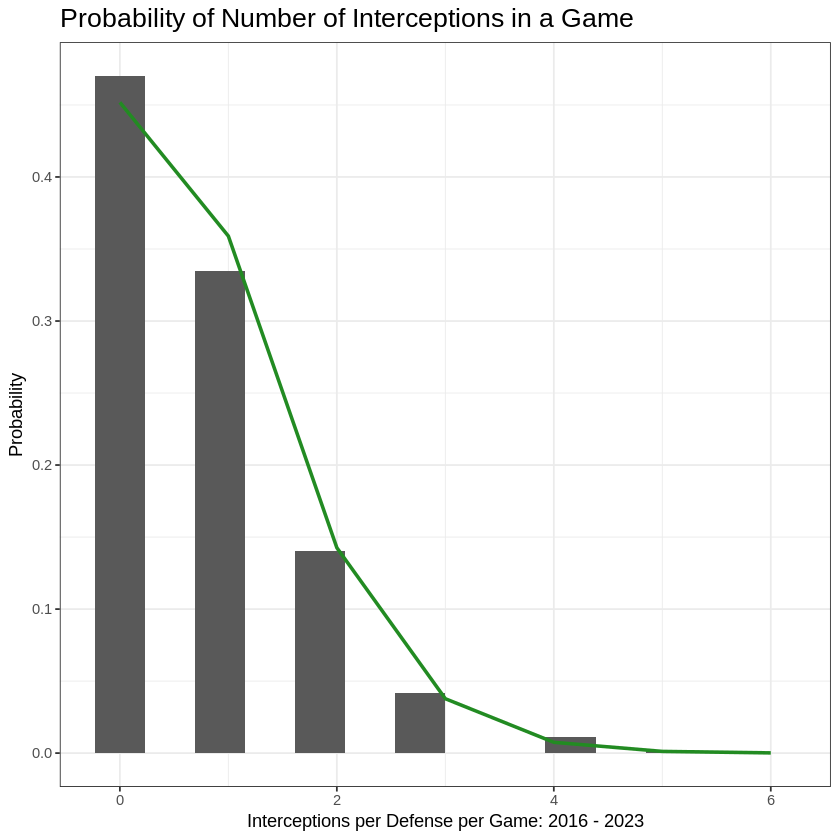

In [ ]:
# Create Plot of Number of Interceptions and correlating interceptions
ggplot() +
  geom_histogram(
    data = pbp_pass_interception,
    aes(interceptions, after_stat(count/ sum(count))),
    bins = 14
  ) +
  geom_line(
    data = plot_poisson,
    aes(x, expected),
    color = 'forestgreen',
    linewidth = 1
  ) +
  theme_bw() +
  xlab('Interceptions per Defense per Game: 2016 - 2023') +
  ylab('Probability') +
  labs(
    title = "Probability of Number of Interceptions in a Game"
  ) +
  theme(
    plot.title = element_text(size = 16)
  )

Fits a poisson distribution fairly well.

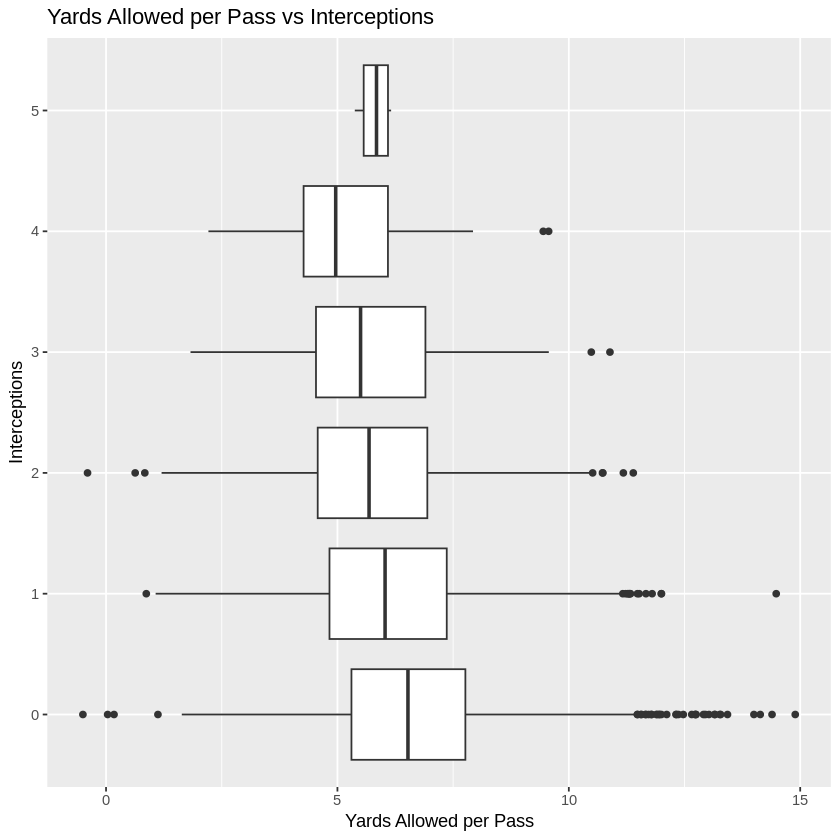

In [ ]:
# Yards per Pass attempt vs Interceptions
pbp_pass_interception |>
  mutate(interceptions = factor(interceptions, levels = c(0,1,2,3,4,5,6), ordered = TRUE)) |>
  ggplot(aes(yards_per_pass, interceptions)) +
    geom_boxplot() +

    labs(
      title = "Yards Allowed per Pass vs Interceptions"
    ) +
    xlab('Yards Allowed per Pass') +
    ylab('Interceptions')

Average number of interceptions in a game increases as yards per pass attempt decreases.

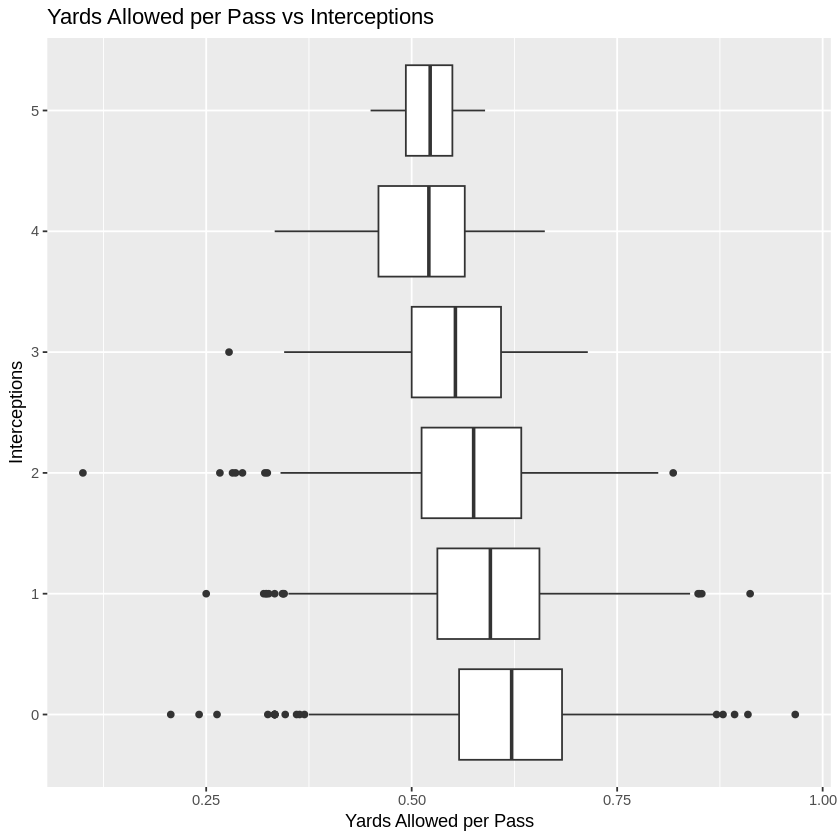

In [ ]:
# Completion Rate vs Interceptions
pbp_pass_interception |>
  mutate(interceptions = factor(interceptions, levels = c(0,1,2,3,4,5,6), ordered = TRUE)) |>
  ggplot(aes(completion_rate, interceptions)) +
    geom_boxplot() +

    labs(
      title = "Completion Rate vs Interceptions"
    ) +
    xlab('Completion Rate') +
    ylab('Interceptions')

Average number of interceptions in a game increases as completion rate decreases.

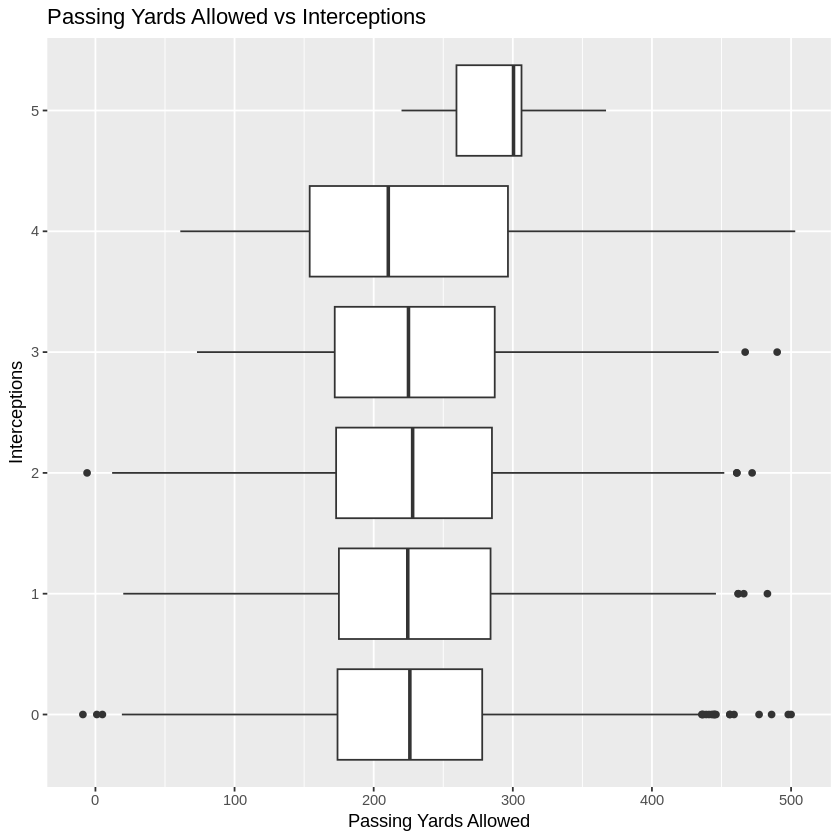

In [ ]:
# Passing Yards Allowed vs Interceptions
pbp_pass_interception |>
  mutate(interceptions = factor(interceptions, levels = c(0,1,2,3,4,5,6), ordered = TRUE)) |>
  ggplot(aes(passing_yards_allowed, interceptions)) +
    geom_boxplot() +

    labs(
      title = "Passing Yards Allowed vs Interceptions"
    ) +
    xlab('Passing Yards Allowed') +
    ylab('Interceptions')

No clear relationship between passing yards allowed in a game vs interceptions.

## Poisson Model

In [ ]:
interception_fit <-
  glm(
    data = pbp_pass_interception,
    interceptions ~ interception_rate + yards_per_pass + completion_rate,
    family = 'poisson'
  )

summary(interception_fit)


Call:
glm(formula = interceptions ~ interception_rate + yards_per_pass + 
    completion_rate, family = "poisson", data = pbp_pass_interception)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        0.25700    0.13734   1.871   0.0613 .  
interception_rate  1.09177    0.08608  12.683   <2e-16 ***
yards_per_pass    -0.02938    0.01254  -2.343   0.0191 *  
completion_rate   -2.05649    0.24098  -8.534   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 4549.9  on 3847  degrees of freedom
Residual deviance: 4177.7  on 3844  degrees of freedom
AIC: 8819.3

Number of Fisher Scoring iterations: 5


Residual deviance of 4177 on 3844 degrees of freedom.

In [ ]:
tidy(interception_fit, exponentiate = TRUE, conf.int = TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.2930407,0.13733635,1.871293,6.130448e-02,0.98717821,1.6912030
interception_rate,2.9795542,0.08608098,12.683099,7.337215e-37,2.51592330,3.5256728
yards_per_pass,0.9710520,0.01253528,-2.343410,1.910838e-02,0.94741006,0.9951264
completion_rate,0.1279017,0.24098019,-8.533869,1.415325e-17,0.07979615,0.2052235


Coefficients:
<ul>
  <li> <b>Interception Rate</b>: Around 200% more interceptions for every additional unit in interception rate.</li>
  <li> <b>Yards per Pass</b>: 3% less interceptions for every additional yard per pass allowed </li>
  <li> <b>Completion Rate</b>: 88% less interceptions for every additional unit increase in completion rate. </li>
  

In [ ]:
pbp_pass_interception <-
  pbp_pass_interception |>
    ungroup() |>
    mutate(
      exp_int = predict(interception_fit, type = 'response')
    )

In [ ]:
pbp_pass_interception <-
  pbp_pass_interception |>
    mutate(
      p_0_int = dpois(
        x = 0, lambda = exp_int
      ),
      p_1_int = dpois(
        x = 1, lambda = exp_int
      ),
      p_2_int = dpois(
        x = 2, lambda = exp_int
      ),
      p_g2_int = 1 - ppois(
        q = 2, lambda = exp_int
      )
    )

In [ ]:
head(pbp_pass_interception)

season,week,defteam,n_passes,passing_yards_allowed,interceptions,yards_per_pass,completion_rate,n_games,interception_rate,exp_pass_td,exp_int,p_0_int,p_1_int,p_2_int,p_g2_int
<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017,1,ARI,44,285,1,6.477273,0.6590909,17,0.8823529,0.7673822,0.7222660,0.4856505,0.3507689,0.12667421,0.036906404
2017,1,ATL,44,176,0,4.000000,0.5909091,20,0.8000000,0.8620642,0.8168609,0.4418164,0.3609025,0.14740359,0.049877502
2017,1,BAL,36,144,4,4.000000,0.4444444,17,1.2941176,1.5585267,1.8934145,0.1505569,0.2850665,0.26987455,0.294502055
2017,1,BUF,41,176,2,4.292683,0.6341463,17,0.8235294,0.8044455,0.7602466,0.4675511,0.3554541,0.13511640,0.041878337
2017,1,CAR,39,166,1,4.256410,0.6153846,17,1.0588235,1.0513764,1.0226777,0.3596307,0.3677863,0.18806341,0.084519666
2017,1,CHI,32,308,0,9.625000,0.6562500,17,0.4705882,0.3260933,0.4225114,0.6553988,0.2769135,0.05849955,0.009188215


In [ ]:
# Chisq goodness of fit test
pchisq(4177.7, 3844, lower.tail = FALSE)

[1] 0.0001042399

Low p-value leads us to believe model does not fit the data well.

## Negative Binomial Model

In [ ]:
install.packages('MASS')
library(MASS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [ ]:
interception_fit_neg_binom <-
  glm.nb(
    data = pbp_pass_interception,
    interceptions ~ interception_rate + yards_per_pass + completion_rate
  )

summary(interception_fit_neg_binom)

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”



Call:
glm.nb(formula = interceptions ~ interception_rate + yards_per_pass + 
    completion_rate, data = pbp_pass_interception, init.theta = 3350.662068, 
    link = log)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        0.25702    0.13736   1.871   0.0613 .  
interception_rate  1.09180    0.08610  12.681   <2e-16 ***
yards_per_pass    -0.02938    0.01254  -2.343   0.0191 *  
completion_rate   -2.05656    0.24102  -8.533   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(3350.662) family taken to be 1)

    Null deviance: 4549.0  on 3847  degrees of freedom
Residual deviance: 4176.8  on 3844  degrees of freedom
AIC: 8821.3

Number of Fisher Scoring iterations: 1


              Theta:  3351 
          Std. Err.:  21332 
Warning while fitting theta: iteration limit reached 

 2 x log-likelihood:  -8811.335 

In [ ]:
tidy(interception_fit_neg_binom, exponentiate = TRUE, conf.int = TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.2930755,0.13735804,1.871193,6.131829e-02,0.98716118,1.6913248
interception_rate,2.9796302,0.08609534,12.681281,7.509411e-37,2.51591651,3.5258665
yards_per_pass,0.9710508,0.01253704,-2.343176,1.912037e-02,0.94740587,0.9951284
completion_rate,0.1278928,0.24101716,-8.532849,1.427871e-17,0.07978472,0.2052239


Similar Coefficients to the Poisson Model.

In [ ]:
pbp_pass_interception <- pbp_pass_interception |>
  mutate(exp_int_nb = predict(interception_fit_neg_binom, type = 'response'))

## Summary

The average NFL defense is expected to get 0.8 interceptions a game. The greatest predictor of interceptions in a game is an interception rate that shows how the defense has preformed as of late. The poisson model has overdispersion, so we elect to go with a negative binomial model.